In [26]:
import time, os

from Bio import Entrez, SeqIO
import pandas as pd
from xml.etree import ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# Always set your email — NCBI requires this
Entrez.email = "prince.leow@sund.ku.dk"

# Optional: set API key if you have one (for higher rate limits)
Entrez.api_key = "f457e32db4ffbfa86487ae28261ba513e408"


search_term = "Candida albicans[Organism]"
handle = Entrez.esearch(db="biosample", term=search_term, retmax=100)
record = Entrez.read(handle)
handle.close()

id_list = record["IdList"]
print(f"Found {len(id_list)} samples.")

if id_list:
    ids = ",".join(id_list)
    fetch_handle = Entrez.efetch(db="biosample", id=ids, rettype="xml")
    biosample_data = fetch_handle.read()
    fetch_handle.close()

    # biosample_data may be bytes or str. Handle both:
    out_path = "../data/candida_albicans_biosamples.xml"
    if isinstance(biosample_data, bytes):
        with open(out_path, "wb") as f:    # write bytes
            f.write(biosample_data)
    else:
        with open(out_path, "w", encoding="utf-8") as f:  # write text
            f.write(biosample_data)

    print(f"Saved sample data to {out_path}")
else:
    print("No samples found.")


Found 100 samples.
Saved sample data to ../data/candida_albicans_biosamples.xml


In [5]:
xml_path = "../data/candida_albicans_biosamples.xml"
# Parse XML
tree = ET.parse(xml_path)
root = tree.getroot()

rows = []
for sample in root.findall(".//BioSample"):
    data = {}
    data["accession"] = sample.attrib.get("accession")
    data["id"] = sample.attrib.get("id")

    # Title (sample name)
    title_elem = sample.find(".//Title")
    data["title"] = title_elem.text if title_elem is not None else None

    # Organism
    org_elem = sample.find(".//Organism/OrganismName")
    data["organism"] = org_elem.text if org_elem is not None else None

    # Attributes (flatten key-value pairs)
    for attr in sample.findall(".//Attribute"):
        key = attr.attrib.get("attribute_name", "unknown").strip()
        value = attr.text.strip() if attr.text else None
        if key in data:  # avoid overwriting if duplicate
            key = key + "_2"
        data[key] = value

    rows.append(data)

# Convert to DataFrame
df = pd.DataFrame(rows)

print(f"Parsed {len(df)} BioSample records.")
print(df.head())

# Save as CSV
out_csv = "../data/candida_albicans_biosamples.csv"
df.to_csv(out_csv, index=False)
print("Saved CSV to", out_csv)

Parsed 100 BioSample records.
      accession        id                                              title  \
0  SAMN50621345  50621345  MISAG Single Amplified Genome sample from Cand...   
1  SAMN50621344  50621344  MISAG Single Amplified Genome sample from Cand...   
2  SAMN50621343  50621343  MISAG Single Amplified Genome sample from Cand...   
3  SAMN50621342  50621342  MISAG Single Amplified Genome sample from Cand...   
4  SAMN50621341  50621341  MISAG Single Amplified Genome sample from Cand...   

           organism       isolate collection_date env_broad_scale  \
0  Candida albicans  C05-KKC-2025   not collected   not collected   
1  Candida albicans  C04-KKC-2025   not collected   not collected   
2  Candida albicans  C03-KKC-2025   not collected   not collected   
3  Candida albicans  C02-KKC-2025   not collected   not collected   
4  Candida albicans  C01-KKC-2025   not collected   not collected   

  env_local_scale     env_medium         geo_loc_name  ... genotype treatm

In [6]:
df

,accession,id,title,organism,isolate,collection_date,env_broad_scale,env_local_scale,env_medium,geo_loc_name,...,genotype,treatment,host,sample_type,Broad-scale Environmental Context,Local-scale Environmental Context,Environmental Medium,isol_growth_condt,tissue,c-source
0,SAMN50621345,50621345,MISAG Single Amplified Genome sample from Cand...,Candida albicans,C05-KKC-2025,not collected,not collected,not collected,not collected,Thailand: Khon Kaen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SAMN50621344,50621344,MISAG Single Amplified Genome sample from Cand...,Candida albicans,C04-KKC-2025,not collected,not collected,not collected,not collected,Thailand: Khon Kaen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SAMN50621343,50621343,MISAG Single Amplified Genome sample from Cand...,Candida albicans,C03-KKC-2025,not collected,not collected,not collected,not collected,Thailand: Khon Kaen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SAMN50621342,50621342,MISAG Single Amplified Genome sample from Cand...,Candida albicans,C02-KKC-2025,not collected,not collected,not collected,not collected,Thailand: Khon Kaen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SAMN50621341,50621341,MISAG Single Amplified Genome sample from Cand...,Candida albicans,C01-KKC-2025,not collected,not collected,not collected,not collected,Thailand: Khon Kaen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SAMN43886186,43886186,stp2Δ/zcf25Δ HQN III,Candida albicans,NaN,missing,NaN,NaN,NaN,missing,...,stp2delta/zcf25delta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,liquid culture,Hydroquinone
96,SAMN43821159,43821159,WT SD I,Candida albicans,NaN,missing,NaN,NaN,NaN,missing,...,wild type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,liquid culture,NaN
97,SAMN43821158,43821158,WT SD II,Candida albicans,NaN,missing,NaN,NaN,NaN,missing,...,wild type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,liquid culture,NaN
98,SAMN43821157,43821157,WT SD II_1,Candida albicans,NaN,missing,NaN,NaN,NaN,missing,...,wild type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,liquid culture,NaN


In [7]:
df.columns

Index(['accession', 'id', 'title', 'organism', 'isolate', 'collection_date',
       'env_broad_scale', 'env_local_scale', 'env_medium', 'geo_loc_name',
       'isolation_source', 'lat_lon', 'source_name', 'strain', 'cell type',
       'genotype', 'treatment', 'host', 'sample_type',
       'Broad-scale Environmental Context',
       'Local-scale Environmental Context', 'Environmental Medium',
       'isol_growth_condt', 'tissue', 'c-source'],
      dtype='object')

In [11]:
SEARCH_TERM = "Candida albicans[Organism] AND genome"
RETMAX = 100
OUT_DIR = "../data/genome"
os.makedirs(OUT_DIR, exist_ok=True)

handle = Entrez.esearch(db="nucleotide", term=SEARCH_TERM, retmax=RETMAX)
record = Entrez.read(handle)
handle.close()

id_list = record.get("IdList", [])
print(f"Found {len(id_list)} records.")

if not id_list:
    print("No genome records found.")

for idx, seq_id in enumerate(id_list, start=1):
    print(f"[{idx}/{len(id_list)}] Fetching GenBank ID {seq_id}...")
    try:
        fetch_handle = Entrez.efetch(db="nucleotide", id=seq_id, rettype="fasta", retmode="text")
        seq_records = list(SeqIO.parse(fetch_handle, "fasta"))
        fetch_handle.close()
        if not seq_records:
            print(f"  ⚠️  No FASTA found for {seq_id}")
            continue

        # Use accession or id as filename
        filename = os.path.join(OUT_DIR, f"{seq_records[0].id}.fasta")

        # Write to file
        SeqIO.write(seq_records, filename, "fasta")
        print(f"  ✅ Saved {filename}")
    except Exception as e:
        print(f"  ❌ Failed {seq_id}: {e}")

    time.sleep(0.3)  # small delay for NCBI courtesy

print("\nAll done! FASTA files saved to:", os.path.abspath(OUT_DIR))

Found 100 records.
[1/100] Fetching GenBank ID 3064943956...


/Users/prince/miniforge3/envs/monolith/lib/python3.13/site-packages/Bio/SeqIO/FastaIO.py:203: BiopythonDeprecationWarning: Previously, the FASTA parser silently ignored comments at the beginning of the FASTA file (before the first sequence).

Nowadays, the FASTA file format is usually understood not to have any such comments, and most software packages do not allow them. Therefore, the use of comments at the beginning of a FASTA file is now deprecated in Biopython.

In a future Biopython release, this deprecation warning will be replaced by a ValueError. To avoid this, there are three options:

(1) Modify your FASTA file to remove such comments at the beginning of the file.

(2) Use SeqIO.parse with the 'fasta-pearson' format instead of 'fasta'. This format is consistent with the FASTA format defined by William Pearson's FASTA aligner software. Thie format allows for comments before the first sequence; lines starting with the ';' character anywhere in the file are also regarded as comm

  ⚠️  No FASTA found for 3064943956
[2/100] Fetching GenBank ID 3040684979...
  ⚠️  No FASTA found for 3040684979
[3/100] Fetching GenBank ID 2967130401...
  ✅ Saved ../data/genome/pdb|9MQU|A.fasta
[4/100] Fetching GenBank ID 2967130400...
  ✅ Saved ../data/genome/pdb|9MQT|A.fasta
[5/100] Fetching GenBank ID 2967130399...
  ✅ Saved ../data/genome/pdb|9MQS|A.fasta
[6/100] Fetching GenBank ID 2964466316...
  ⚠️  No FASTA found for 2964466316
[7/100] Fetching GenBank ID 2964462378...
  ⚠️  No FASTA found for 2964462378
[8/100] Fetching GenBank ID 2964458267...
  ⚠️  No FASTA found for 2964458267
[9/100] Fetching GenBank ID 2949642251...
  ⚠️  No FASTA found for 2949642251
[10/100] Fetching GenBank ID 2949628994...
  ⚠️  No FASTA found for 2949628994
[11/100] Fetching GenBank ID 2845728557...
  ⚠️  No FASTA found for 2845728557
[12/100] Fetching GenBank ID 2845727158...
  ⚠️  No FASTA found for 2845727158
[13/100] Fetching GenBank ID 2845727136...
  ⚠️  No FASTA found for 2845727136
[14/10

In [24]:
headers = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore".split(" ")
df = pd.read_table("../data/results.out", names=headers)
# remove self-hits
df = df[~(
    df["qseqid"] == df["sseqid"]
)]

In [25]:
df.sort_values("length", ascending=False).head(10)

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
30,NC_018046.1,NC_002653.1,99.036,24171,226,5,5681,29848,12053,36219,0.0,43338.0
71,NC_018046.1,JBEPJV010000009.1,98.285,14405,195,23,8197,22563,14605,28995,0.0,25185.0
120,NC_018046.1,CM084639.1,98.285,14405,195,23,8197,22563,14605,28995,0.0,25185.0
121,NC_018046.1,CM084639.1,99.327,7286,49,0,22563,29848,29044,36329,0.0,13184.0
72,NC_018046.1,JBEPJV010000009.1,99.327,7286,49,0,22563,29848,29044,36329,0.0,13184.0
73,NC_018046.1,JBEPJV010000009.1,99.438,5692,20,6,1,5691,1,5681,0.0,10323.0
31,NC_018046.1,NC_002653.1,99.069,5692,49,4,1,5691,1,5689,0.0,10214.0
122,NC_018046.1,CM084639.1,99.438,5692,20,6,1,5691,1,5681,0.0,10323.0
33,NC_018046.1,NC_002653.1,97.809,3606,62,17,29846,33442,36272,39869,0.0,6205.0
32,NC_018046.1,NC_002653.1,97.809,3606,62,17,29846,33442,9688,6091,0.0,6205.0


<Axes: xlabel='length', ylabel='Count'>

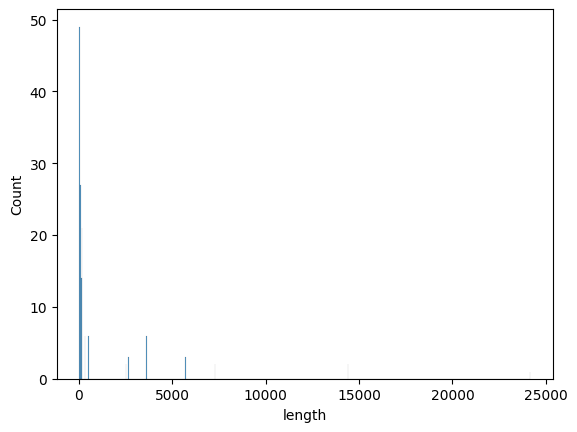

In [30]:
sns.histplot(data=df, x = "length")

<Axes: xlabel='length', ylabel='Count'>

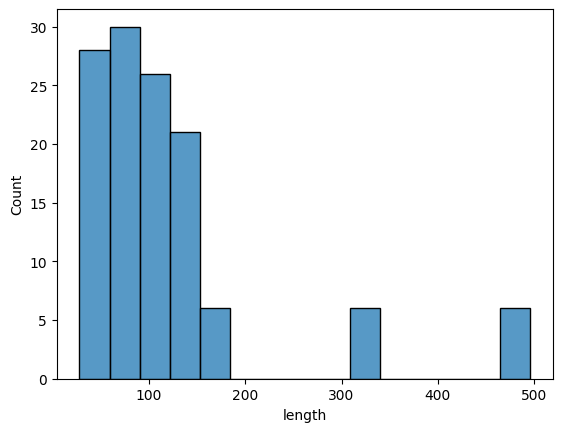

In [29]:
sns.histplot(data=df[df["length"] < 2000], x = "length")